In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Linear regression library
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Pytorch for neural network
import torch.nn as nn
import torch.nn.functional as F
import torch

# Path to files
agg_trades = '../data/processed/aggregated_trades'

In [9]:
# Load the data
folders = os.listdir(agg_trades)

# Creating array to store explanatory and predicted variables
X_ = []
y_ = []

# Going through all stocks
for stock in folders:
    # Get all files
    files = os.listdir(f'{agg_trades}/{stock}')

    for date in files:
        # Loading the data
        df = pd.read_parquet(f'{agg_trades}/{stock}/{date}')

        # Get returns
        price = df['price'].values
        return_ = price[1:] / price[:-1] - 1

        # Add variables
        X_.append(return_[:-1])
        y_.append(return_[-1])

X_ = np.array(X_)
y_ = np.array(y_)

# Splitting
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Linear Regression

In [110]:
mse_errs = []
mae_errs = []
for i in range(X_train_.shape[1]):
    # Remove features
    X_train = X_train_[:, i:]
    X_test = X_test_[:, i:]

    # Fitting the model
    model = LinearRegression()
    model.fit(X_train, y_train_)

    # Predicting
    y_pred = model.predict(X_test)

    # Compute mse and mae
    mse = mean_squared_error(y_test_, y_pred)
    mae = mean_absolute_error(y_test_, y_pred)

    mse_errs.append(mse)
    mae_errs.append(mae)



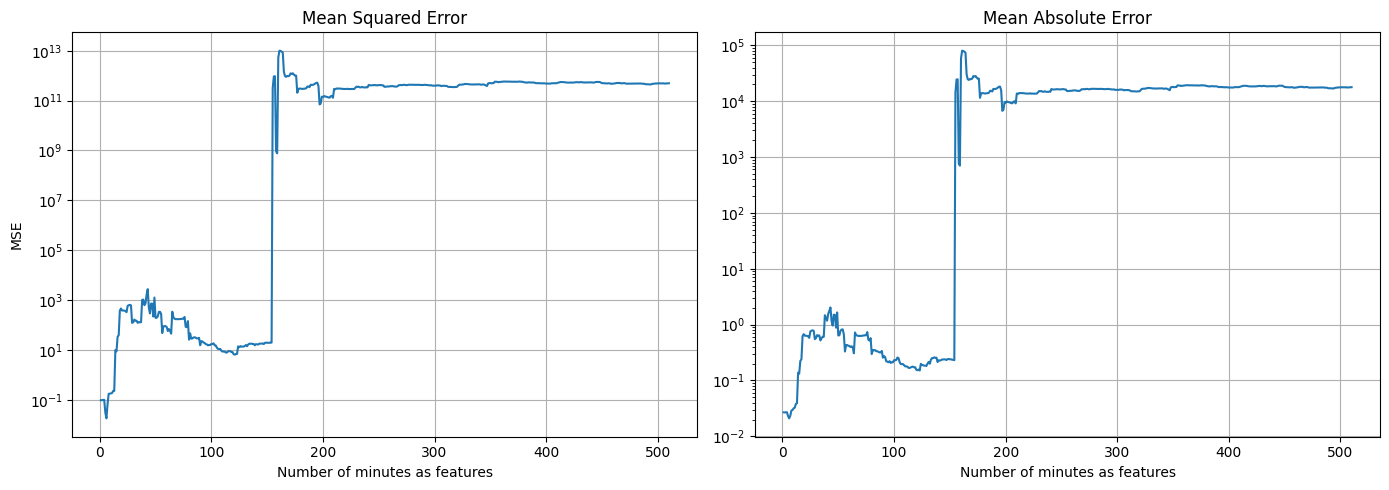

In [111]:
# Create figure
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# X axis
x = np.arange(X_train_.shape[1])[::-1] + 1

# Plotting mse
ax[0].plot(x, mse_errs)
ax[0].set_title('Mean Squared Error')
ax[0].set_xlabel('Number of minutes as features')
ax[0].set_ylabel('MSE')

# Plotting mae
ax[1].plot(x, mae_errs)
ax[1].set_title('Mean Absolute Error')
ax[1].set_xlabel('Number of minutes as features')

# Settings for both plots
for i in range(2):
    ax[i].grid()
    ax[i].set_yscale('log')
fig.tight_layout()
# Saving
plt.savefig('../figures/linear_regression.png')


In [140]:
# Index where mae and mse are minimized
min_mse = np.argmin(mse_errs)
min_mae = np.argmin(mae_errs)

print(f'Minimum MSE: {x[min_mse]} minutes')
print(f'Minimum MAE: {x[min_mae]} minutes')

# Remodel with the best number of features
X_train = X_train_[:, min_mse:]
X_test = X_test_[:, min_mse:]

# Fitting the model
model = LinearRegression()
model.fit(X_train, y_train_)
y_pred = model.predict(X_test)

# Compute mse and mae
mse = mean_squared_error(y_test_, y_pred)
mae = mean_absolute_error(y_test_, y_pred)

# Get coefficients and intercept
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

text = f'r_T = {model.intercept_:.3f}'
for i, coef in enumerate(model.coef_[::-1]):
    text += f' + {coef:.3f} \\cdot r_{{T_{-i-1}}}'
text

Minimum MSE: 6 minutes
Minimum MAE: 6 minutes
Coefficients: [ 0.18834898  1.57810763  0.17986606  1.41114076  0.45259379 -9.03860235]
Intercept: 0.013396044313556645


'r_T = 0.013 + -9.039 \\cdot r_{T_-1} + 0.453 \\cdot r_{T_-2} + 1.411 \\cdot r_{T_-3} + 0.180 \\cdot r_{T_-4} + 1.578 \\cdot r_{T_-5} + 0.188 \\cdot r_{T_-6}'

# Neural Network


In [59]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.input = nn.Linear(input_size, 128)
        self.output = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.output(x)
        return x

# Converting to tensors
X_train_tensor = torch.tensor(X_train_, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_.reshape(-1, 1), dtype=torch.float32)


In [72]:
# Going through number of features
mse_errs = []
mae_errs = []
batch_size = 1024
epochs = 100
for i in range(X_train_tensor.shape[1]):
    X_train = X_train_tensor[:, i:]
    X_test = X_test_tensor[:, i:]

    # Convert to dataloader
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Model and optimizer
    model = NeuralNetwork(X_train.shape[1])
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training
    for epoch in range(epochs):
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_train_batch)
            loss_ = loss(y_pred, y_train_batch)
            loss_.backward()
            optimizer.step()

    # Testing
    y_pred = model(X_test).detach().numpy()
    mse = mean_squared_error(y_test_, y_pred)
    mae = mean_absolute_error(y_test_, y_pred)

    # Saving
    mse_errs.append(mse)
    mae_errs.append(mae)

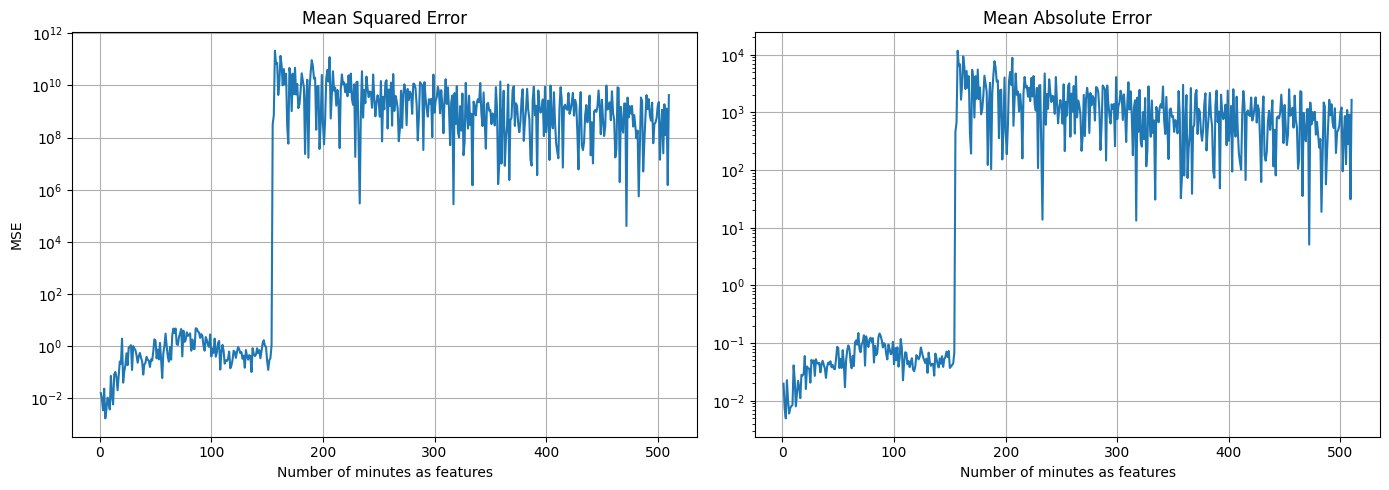

In [76]:
# Create figure
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# X axis
x = np.arange(X_train_.shape[1])[::-1] + 1

# Plotting mse
ax[0].plot(x, mse_errs)
ax[0].set_title('Mean Squared Error')
ax[0].set_xlabel('Number of minutes as features')
ax[0].set_ylabel('MSE')

# Plotting mae
ax[1].plot(x, mae_errs)
ax[1].set_title('Mean Absolute Error')
ax[1].set_xlabel('Number of minutes as features')

# Settings for both plots
for i in range(2):
    ax[i].grid()
    ax[i].set_yscale('log')
fig.tight_layout()
# Saving
plt.savefig('../figures/neural_network.png')


In [78]:
# Where mae and mse minimised
min_mse = np.argmin(mse_errs)
min_mae = np.argmin(mae_errs)

print(f'Minimum MSE: {x[min_mse]} minutes')
print(f'Minimum MAE: {x[min_mae]} minutes')

Minimum MSE: 5 minutes
Minimum MAE: 3 minutes


In [81]:
min(mse_errs)

0.0016845398603238238

In [22]:
30 * 100

3000